# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import shutil
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

ModuleNotFoundError: No module named 'pandas'

### input parameters

In [10]:
### CHANGE FILE/DIRECTORY NAMES
parameterfile = "/home/nzjacic/Desktop/pharaglow_parameters_mks.txt"
inPath = "home/mscholz/Dropbox%20(Scholz%20Lab)/Shared/Data/"
outPath = "/home/mscholz/Desktop/"
lawnPath = None #"/opt/data/Lawns/"
movie = "MS0006_0_1000frames"
nWorkers = 5

### Load data and create binary masks 

In [11]:
%%time

movieID = movie[-6:]
if lawnPath is not None and lawnPath != 'None':
    try:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.tiff')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
    except Exception:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.bmp')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
else:
    lawnfile = None


# creating new file names
fname = os.path.join(inPath,"*.tiff")
outfile = os.path.join(outPath, movieID+"_{}_{}.json")
print(outfile)
saveparam = os.path.join(outPath, movieID+"_parameters")
print(saveparam)

# starting pharaglow
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes#[:2000]
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)
    

/home/nzjacic/Desktop/Harddrive/10x_GRU101_freshlawn_analyzed/NH0021_{}_{}.json
/home/nzjacic/Desktop/Harddrive/10x_GRU101_freshlawn_analyzed/NH0021_parameters
Starting pharaglow analysis...
Loading parameters from ['Desktop', 'pharaglow_parameters_mks.txt']
CPU times: user 161 ms, sys: 16 ms, total: 177 ms
Wall time: 176 ms


### Improve lawn detection if neccessary

In [12]:
if lawnfile is not None:
    from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
    from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
    image = gaussian(lawn, 1, preserve_range = True)
    thresh = threshold_li(image, initial_guess = np.median)
    binary = image > thresh*0.5
    binary = remove_small_holes(binary, area_threshold=1500, connectivity=1, in_place=False)
    binary = remove_small_objects(binary, min_size=5000, connectivity=8, in_place=False)
    binLawn = binary
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(lawn)
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    plt.subplot(122)
    plt.imshow(binLawn)

### Examining raw data

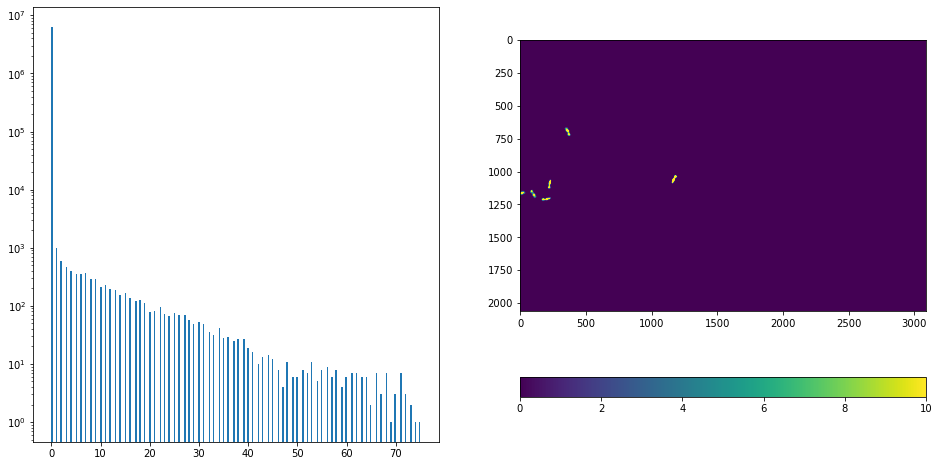

In [32]:
plt.figure(figsize=(16,8))
# histogram of pixel intensity values
plt.subplot(121)
plt.hist(rawframes[t].ravel(), bins=256, log=True)
# worm visualization where color = intensity - can chance clim
plt.subplot(122)
plt.imshow(rawframes[t], clim=(0,10)) # 0<=clim<=256
plt.colorbar(orientation='horizontal');

### Create binary masks

In [13]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate = param['dilate'] , tfactor=param['tfactor'])


Binarizing images
CPU times: user 3.07 s, sys: 156 ms, total: 3.22 s
Wall time: 3.23 s


### Make sure the thesholding worked otherwise change parameters

False


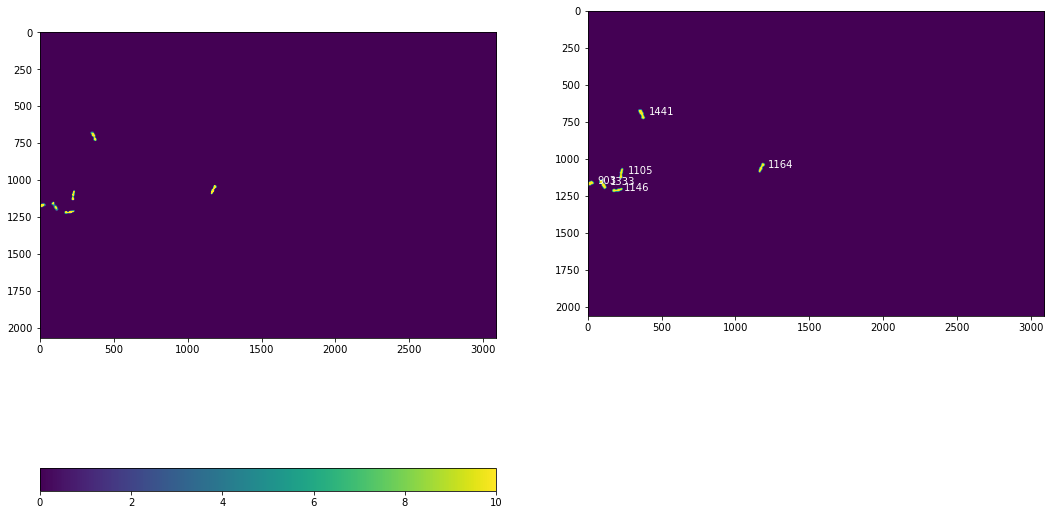

In [26]:
from skimage.measure import label, regionprops
t = 1000
plt.figure(figsize=(18,16))
plt.subplot(121)
plt.imshow(rawframes[t])#+lawn)
if lawnfile is not None:
    plt.contour(binLawn, alpha=0.5, cmap='pink')
plt.subplot(122)
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
print(np.min(masks[t]))
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')
plt.subplot()

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [ ]:
import time
from multiprocessing import Pool

chunksize = 100#
def parallelDetection(rawframes, masks, nWorkers):
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
   
    #slice the movie into pieces to run
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    jobs = []
    for (a,b) in slices:
        jobs.append([rawframes[a:b+1], masks[a:b+1], param, a])
    # delete jobs of length 1
    jobs = [j for j in jobs if len(j[0])>1]
    #run the parallel feature detection.
    features = []
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(tracking.parallelWorker, jobs)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
    
    p.close()
    p.join()
    features = pd.concat(features)
    return features

In [ ]:
%%time
print('Detecting features')
if nWorkers ==1 or len(rawframes) < chunksize:
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    features = parallelDetection(rawframes, masks, nWorkers)

In [ ]:
### Show the area of all objects
plt.plot(np.sort(features['area'].values))

### Save features

In [ ]:
# # trajectories
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

# saving parameter file
shutil.copyfile(parameterfile, saveparam, follow_symlinks=True)

### Load all features

In [ ]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

### Link objects to trajectories and interpolate short misses

In [ ]:
print('Done')
print('Linking trajectories')
#pred = tp.predict.NearestVelocityPredict()
#trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])
trajectories = tp.link_df(features,param['searchRange'], memory = param['memory'])

In [ ]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    # make new columns for the offset
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj, ignore_index = True)
trajectories['shapeX'] = trajectories['shapeX'].astype(int)
trajectories['shapeY'] = trajectories['shapeY'].astype(int)

In [ ]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, superimpose=1-masks[900]);

In [ ]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
print(trajectories['particle'].nunique())

In [ ]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, superimpose=1-masks[900]);

### add the missing images to interpolated trajectories

In [ ]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
# interpolate the shape parameter

trajectories[['image', 'slice', 'shapeY', 'shapeX']] = trajectories.apply(\
       lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                               lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else pd.Series([row['image'], row['slice'], row['shapeY'], row['shapeX']]), axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['diffI'])) else row['diffI'], axis=1)
#trajectories[['diffI']] = trajectories.apply(\
#         lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
#                                                 lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.sum((row['diffI']))==0 else row['diffI'], axis=1)

### Extract lawn info

In [ ]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

### Show resulting trajectories

In [ ]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[500]);

In [ ]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')

### check slow-down before continuing analysis

In [ ]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 1000
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            print('t0:', t0)
            try:
                if t0>dt:
                    print('pid:', pid)
                    time = np.linspace(0,2*dt/30., 2*dt)
                    #print('time:', len(time))
                    v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                    #print('v:', v)
                    #print('v.iloc:', v.iloc[t0-dt:t0+dt])
                    plt.plot(time, v.iloc[t0-dt:t0+dt], 'navy', alpha=0.1)
                    vcut.append(v.iloc[t0-dt:t0+dt].values)
                else:
                    print('trajectory is too short')
            except ValueError:
                print('t0-dt or t0+dt exceeds number of frames')
                continue
                    
    if len(vcut) >0:  
        plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
        plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
        plt.axvline(dt/30, color='k', linestyle='--')
        plt.ylabel(r"velocity ($\mu$m/s)");
        plt.xlabel("time (s)");
        plt.ylim(0,150)

### run the whole pharaglow feature extraction

In [ ]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

#### run this if acidentally used an odd length like an idiot.

In [ ]:
def padIm(im, size = 22500):
    return np.pad(im, (0,size-len(im)), mode='constant', constant_values=0)

def fixImages(trajectories):
    trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['image'], row['shapeX']*row['shapeY'])) if len(row['image'])<row['shapeX']*row['shapeY'] else row['image'], axis=1)
    trajectories[['diffI']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['diffI'], row['shapeX']*row['shapeY'])) if len(row['diffI'])<row['shapeX']*row['shapeY'] else row['diffI'], axis=1)


### Save data as json format (every trajectory in a file)

In [ ]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    print(fn)
    if os.path.isfile(file) and f'{movieID}_trajectories_' in fn and fn.endswith('.json'):
        print(fn)
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split', numpy = True)
        # check if the images are non-zero
        if not np.all(np.array([np.sum(im) for im in traj['image']])>0):
            continue
        traj['shapeX'] = traj['shapeX'].astype(int)
        print('Analyzing trajectory:', fn)
        # interpolate if images are not the right size:
        fixImages(traj)
        #tmp = run.runPharaglowOnStack(traj, param)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = nWorkers, params = param)
        # get more exact entry location
        if lawnfile is not None:
            tmp['insideHead'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], binLawn)), axis=1)
            tmp['insideHeadIntensity'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], lawn)), axis=1)
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        